#### Implementing DivGraphPointer paper from https://arxiv.org/abs/1905.07689


In [1]:
import os
import numpy as np
import pandas as pd
import string
import re
from itertools import chain
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

## Loading the dataset

In [2]:
import spacy
nlp = spacy.load('en_core_web_md')

In [3]:
news = pd.read_json('../data/KEDatasets/KPTimes/KPTimes.train.jsonl', lines=True)

In [4]:
news.head(2)

,id,categories,date,title,abstract,keyword
0,ny0282969,"[us, politics]",2016-07-21,"For Donald Trump’s Big Speech, an Added Pressu...","CLEVELAND — Until Monday night, Donald J. Trum...",2016 Presidential Election;Donald Trump;Republ...
1,ny0225578,"[sports, hockey]",2010-10-16,"In Home Opener, Rangers Lose Gaborik and Drury...",There were silver linings to the Rangers ’ wil...,Hockey Ice;Toronto Maple Leafs;New York Ranger...


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

In [7]:
import time
from datetime import datetime

In [8]:
import networkx as nx
import numpy as np
import torch
import torch.optim as optim

In [9]:
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Dataset
import torch_geometric.transforms as T
from torch_geometric import utils

In [10]:
#from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Importing FastText and loading a model for word vectors

In [11]:
import fasttext as ft

In [12]:
ft_model = ft.load_model('../models/fil9SkipGram.bin')

#### Most similar words to 'man' according to the model

In [13]:
ft_model.get_nearest_neighbors('man')

[(0.7125452756881714, 'woman'),
 (0.7092046141624451, 'stranger'),
 (0.7067620754241943, 'stupider'),
 (0.7021083235740662, 'thing'),
 (0.7005878686904907, 'darndest'),
 (0.6971448063850403, 'stupidest'),
 (0.692797839641571, 'beastly'),
 (0.6923372745513916, 'beast'),
 (0.6917076110839844, 'hater'),
 (0.6898659467697144, 'niggardly')]

This FastText model is trained only on a small subset of Wikipedia articles. It is much faster to load for daily experiments. The final version of the FastText model will be trained on the full Wikipedia dataset and fine-tuned for the KPTimes articles.

*Checking the KPTimes dataset for the duplicates.*

In [14]:
news['abstract'].duplicated().sum(), news.isnull().sum()

(21,
 id            0
 categories    0
 date          0
 title         0
 abstract      0
 keyword       0
 dtype: int64)

*What are the most popular categories for the news articles?*

In [15]:
news = news.drop_duplicates(subset='abstract').reset_index(drop=True)
news['keyword'] = news['keyword'].str.split(';')
news = news.explode('categories')
news['categories'].value_counts()

sports              61996
world               50828
business            49690
us                  41124
nyregion            40131
                    ...  
nyregionspecial5        1
election-news           1
worldspecial3           1
businessspecial6        1
nyregionspecial         1
Name: categories, Length: 92, dtype: int64

Now choosing only three most popular categories (sports, world and business), taking small number of articles from each of them and creating a new DataFrame.

In [16]:
np.random.seed(42)
topics = ['sports', 'world', 'business']
sports_id = news.loc[news['categories'] == 'sports'].index
world_id = news.loc[news['categories'] == 'world'].index
bus_id = news.loc[news['categories'] == 'business'].index
id1 = np.random.choice(sports_id, 20, replace=False).tolist()
id2 = np.random.choice(world_id, 20, replace=False).tolist()
id3 = np.random.choice(bus_id, 20, replace=False).tolist()
ids = id1 + id2 + id3
df = news[['abstract', 'categories', 'keyword']].loc[ids].copy()

In [17]:
df.shape

(108, 3)

60 articles in the new smaller DataFrame.

In [18]:
df = df.drop_duplicates('abstract').reset_index(drop=True)
df.shape

(60, 3)

### Cleaning the text and creating a vocabulary (nodes)

In [19]:
######################## cleaning the text, splitting into chunks #########################################
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stops = ENGLISH_STOP_WORDS
signs = string.punctuation + '“' + '’' + '”' + '*'
punct_translator = str.maketrans('', '', signs)

def clean_chunks(chunks):
    new_chunks = []
    for pair in chunks:
        text = pair[0].translate(punct_translator)
        words = text.split()
        nchunk = ' '.join([w for w in words if w not in ENGLISH_STOP_WORDS])
        if len(text) > 2:
            new_chunks.append((nchunk, pair[1]))
    return new_chunks
            

def get_nchunks(x):
    nchunks = []
    #import pdb;pdb.set_trace()
    chunks = nlp(x).noun_chunks
    nchunks = [(c.text.lower(), (c.start_char, c.end_char)) 
               for c in chunks if c.text.lower() not in ENGLISH_STOP_WORDS]
    new_chunks = clean_chunks(nchunks)

    return new_chunks

In [20]:
#################################### creating vocabulary (nodes) ############################################################
def make_vocab(x):
    nchunks = x[3]
    #import pdb;pdb.set_trace()
    ss = x[0].lower()
    #print(ss)
    spans = list(list(zip(*nchunks))[1])
    keys = list(list(zip(*nchunks))[0])
    spans.extend([(len(ss),)])
    keys_ids = list(zip(keys, list(zip(*spans))[0]))
    non_chunks = [(ss[0:spans[0][0]], 0)]+[(ss[spans[i][-1]:spans[i+1][0]-1], spans[i][-1])
                                      for i in range(len(spans)-1)]
    non_chunks.extend(keys_ids)
    #print(non_chunks)
    words = list(zip(*sorted(non_chunks, key=lambda x: x[1])))[0]
    #print(words)
    vocab = []
    for w in words:
        if w not in keys:
            w = w.translate(punct_translator).lower().split()
            for i in w:
                if i not in ['', ' ', '  ', '   ']:
                    vocab.append(i)
        else: vocab.append(w)
    return vocab

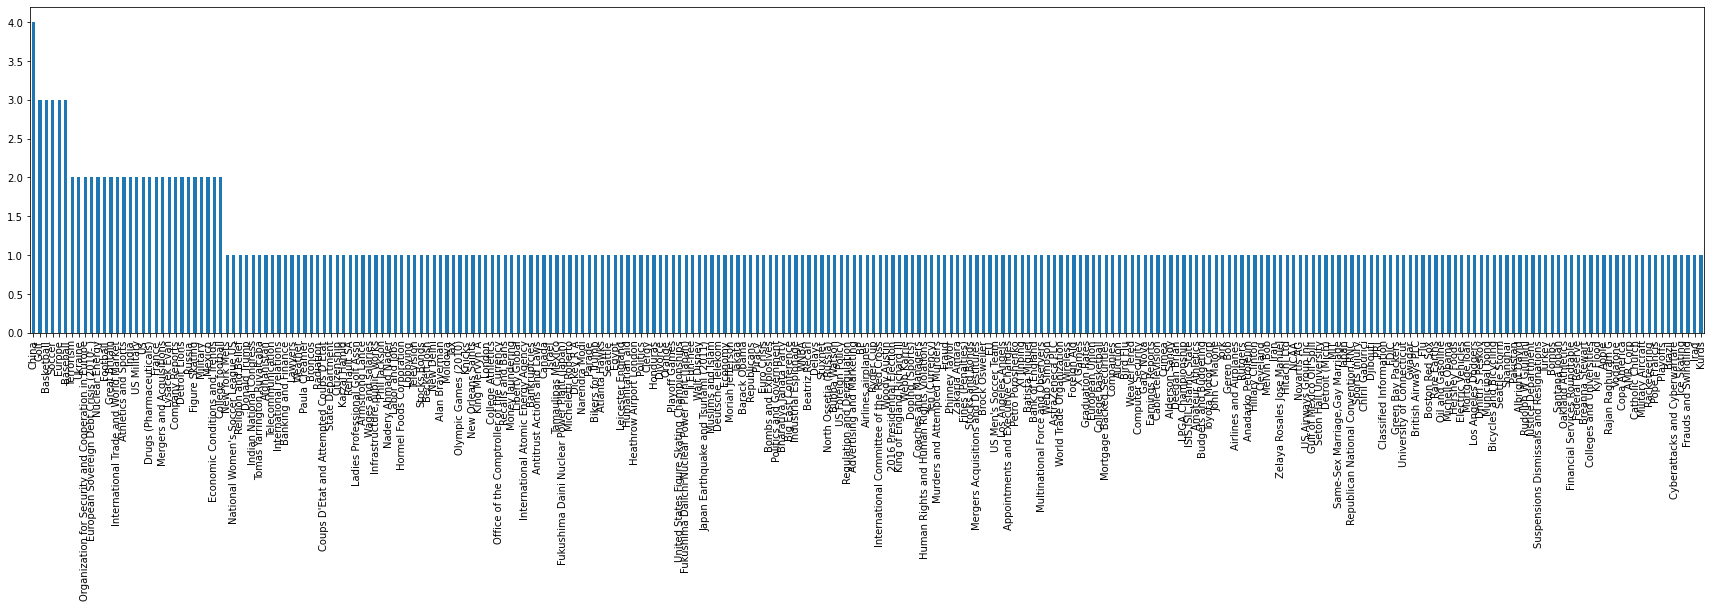

In [21]:
df.explode('keyword')['keyword'].value_counts().plot(kind='bar', figsize=(30, 6));

In [22]:
%time df['nchunks'] = df.loc[:, 'abstract'].apply(get_nchunks)

CPU times: user 4.96 s, sys: 0 ns, total: 4.96 s
Wall time: 4.96 s


In [23]:
%time df['vocab'] = df.apply(make_vocab, axis=1)

CPU times: user 57.7 ms, sys: 0 ns, total: 57.7 ms
Wall time: 57.7 ms


In [24]:
def clean_vocab(v):
    return [w for w in v if (w not in stops) and (len(w) > 3)]

df['vocab'] = df.loc[:, 'vocab'].apply(clean_vocab)

In [25]:
df.sort_values(by='abstract', key=lambda x: x.str.len()).iloc[0]['vocab']

['coach kyle flood',
 'said',
 'senior gary nova',
 'benched',
 'games',
 'season',
 'start',
 'quarterback',
 'rutgers']

In [26]:
s = 'peter piper picked a peck of pickled pepper where is the peck of pickled '\
    'pepper peter piper picked'
w = np.array(s.split())


In [27]:
def position_score(pos1, pos2):

    score = 0
    for i in pos1:
        for j in pos2:
            score += max(0, 1/(i-j))
    return score

def position_dict(ordered_vocab):
    
    position_dict = OrderedDict()
    for word in ordered_vocab:
        if word not in position_dict.keys():
            position_dict[word] = [i for i, w in enumerate(ordered_vocab) if w == word]
    return position_dict

def score_matrix(ordered_vocab):
    
    pos = position_dict(ordered_vocab)
    A_left = []
    A_right = []
    for word in pos.keys():
        left = []
        right = []
        for word2 in pos.keys():
            if word == word2:
                left.append(0)
                right.append(0)
            else:
                left_score = position_score(pos[word], pos[word2])
                left.append(left_score)
                right_score = position_score(pos[word2], pos[word])
                right.append(right_score)
        A_left.append(left)
        A_right.append(right)
    return np.array(A_left), np.array(A_right), pos.keys()

In [28]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNWeightedConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNWeightedConv, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.left_lin = torch.nn.Linear(in_channels, out_channels)
        self.right_lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):#, left_deg, right_deg):

        self.x = x
        linear_x = self.lin(x)
        #left_x = self.left_lin(x)
        #right_x = self.right_lin(x)
        
        row, col = edge_index
        left_deg = left_deg.pow(-0.5)
        right_deg = right_deg.pow(-0.5)
        left_norm = left_deg[row] * left_deg[col]
        right_norm = right_deg[row] * right_deg[col]

        left = self.propagate(edge_index, x=left_x, norm=left_norm)
        right = self.propagate(edge_index, x=right_x, norm=right_norm)
        
        
        return left + right + linear_x

    
    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j
    
    
    def update(self, aggr_out):
        
        return aggr_out

In [29]:
class GCNWeightedConvM(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNWeightedConvM, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)
        #self.left_lin = torch.nn.Linear(in_channels, out_channels)
        #self.right_lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, X, A_left_tilda, A_right_tilda):#, left_deg, right_deg):

        
        D_right = torch.diag_embed(A_right_tilda.sum(dim=1).pow(-0.5))
        D_left = torch.diag_embed(A_left_tilda.sum(dim=1).pow(-0.5))
        
        A_left_hat = D_left @ A_left_tilda
        A_right_hat = D_right @ A_right_tilda
        
        f = self.propagate(X, A_left_hat, A_right_hat)
        g = torch.sigmoid(f)
        
        activation = (f * g)
        if X.size() == activation.size():
            return X + activation
        return activation
    
    def propagate(self, X, A_left, A_right):
        
        left = self.lin(A_left.float() @ X.float())
        right = self.lin(A_right.float() @ X.float())
        linear = self.lin(X)
        
        return left + right + linear

In [30]:
Aleft, Aright, columns = score_matrix(w)
Aleft_tilda = torch.from_numpy(Aleft + np.identity(Aleft.shape[0]))
Aright_tilda = torch.from_numpy(Aright + np.identity(Aright.shape[0]))
X = torch.tensor([ft_model.get_sentence_vector(w).tolist() for w in columns])

In [31]:
example_data = Data(x=X)

In [32]:
example_data.a_left = Aleft_tilda
example_data.a_right = Aright_tilda
example_data.words = columns

In [34]:
#divG = DivGraphEncoder(example_data.num_node_features, example_data.num_node_features, 3)
#optimiser = optim.Adam(divG.parameters(), lr=0.01)

In [ ]:
#%load_ext tensorboard

In [35]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [36]:
def train_encoder(data_obj, model, opt, nepochs):
    for epoch in range(nepochs):
        model.train()
        opt.zero_grad()
        #print('X shape', data_obj.x.shape)
        embedding = model(data_obj)
        #import pdb;pdb.set_trace()
        writer.add_histogram('linear.weight', 
                             dict(model.named_parameters())['linear.weight'],
                            epoch)
        writer.add_histogram('convs.0.lin.weight', 
                             dict(model.named_parameters())['convs.0.lin.weight'],
                            epoch)
        writer.add_histogram('convs.1.lin.weight', 
                             dict(model.named_parameters())['convs.1.lin.weight'],
                            epoch)
        writer.add_histogram('convs.2.lin.weight', 
                             dict(model.named_parameters())['convs.2.lin.weight'],
                            epoch)
        #data_obj.x = embedding

    return embedding, dict(model.named_parameters())['convs.2.lin.weight']


In [37]:
#%%time
#div_embeds10, last_conv_w10 = train_encoder(example_data, divG, 
#                                        optimiser, 10)
#div_embeds100, last_conv_w100 = train_encoder(example_data, divG, 
#                                        optimiser, 100)
#div_embeds500, last_conv_w500 = train_encoder(example_data, divG, 
#                                        optimiser, 500)

In [ ]:
#div_embeds, last_conv_w = train_encoder(example_data, divG, 
#                                        optimiser, 1)

In [ ]:
#%tensorboard --logdir=runs

In [ ]:
#div_embeds.shape, last_conv_w.shape

In [ ]:
#plt.bar(range(11), example_data.x.mean(dim=1).detach().numpy())
#plt.xticks(range(11), example_data.words, rotation=20)
#plt.title('Means of the word vector coordinates, FastText');

In [ ]:
#plt.bar(range(11), div_embeds.mean(dim=1).detach().numpy(), color='green')
#plt.xticks(range(11), example_data.words, rotation=20)
#plt.title('Means of the word vector coordinates, DivGraphConv');

In [ ]:
#projector = SummaryWriter()

In [ ]:
#projector.add_embedding(mat=example_data.x, metadata=list(example_data.words))

In [ ]:
#%tensorboard --logdir=runs

In [ ]:
#ft_projector = SummaryWriter(log_dir='logs')

In [ ]:
#ft_projector.add_embedding(mat=div_embeds, metadata=list(example_data.words),
#                          global_step='DivG2')

In [ ]:
#%reload_ext tensorboard
#projector.close()
#writer.close()

In [ ]:
#%tensorboard --logdir='logs'

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [39]:
class DivGraphNet(torch.nn.Module):
    
    def __init__(self, encoder, decoder):
        super(DivGraphNet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
        self.y_W = nn.Linear(self.decoder.embed_size, self.decoder.embed_size) 
        self.h_W = nn.Linear(self.decoder.embed_size, self.decoder.hidden_size)
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, batch, labels):
        
        # encoder_out.shape for one article = (n_words, 100)
        keyphrases = []
        # encoder_out: (11, 100)
        encoder_out = self.encoder(batch)
        # context_vector: (1, 100)
        context_vector = encoder_out.mean(axis=0)
        loss = 0
        nodes = torch.cat((encoder_out, torch.ones(1, encoder_out.size(1))), 0)
        coverage = torch.zeros(len(nodes), 1)
        hidden_dim = self.decoder.bi*self.decoder.rnn_layers
        for l in range(len(labels)):
            
            if l == 0:
                # input_token: (1, 1, 100)
                input_token = torch.zeros((1, 1, self.decoder.embed_size))
                # hidden: (1, 1, 300)
                hidden = torch.tanh(self.h_W(context_vector)).unsqueeze(0).unsqueeze(0)
            else:
                # ids: (1, ...)
                #import pdb;pdb.set_trace()
                ids = list(chain.from_iterable(keyphrases))
                # kp: (100,)
                kp = nodes[ids, :].mean(axis=0)
                # context_vector*kp: (1, 100)
                # cy: (100,)
                cy = (context_vector*kp)
                # input_token: (1, 1, 100)
                input_token = self.y_W(cy).unsqueeze(0).unsqueeze(0)
                # hidden: (1, 1, 300)
                hidden = torch.tanh(self.h_W(cy)).unsqueeze(0).unsqueeze(0)
            
            keyphrases.append([])

            for i in range(len(labels[l])): 

                att_w, hidden, word_id = self.decoder(input_token, 
                                                      hidden,
                                                      nodes,
                                                      coverage)
                
                if word_id == (len(nodes)-1):
                    keyphrases[-1].append(word_id)
                    loss += self.loss(att_w.unsqueeze(0), 
                                  torch.tensor(labels[l][i]))
                    break
                input_token = nodes[word_id].unsqueeze(0).unsqueeze(0)
                keyphrases[-1].append(word_id)
                coverage = coverage.clone()
                coverage[word_id] += 1
                # sum the loss up like this 
                # or return predictions and compute the loss for the
                # whole batch in the training loop?
                loss += self.loss(att_w.unsqueeze(0), 
                                  torch.tensor(labels[l][i]))
        
        return keyphrases, loss


class DivGraphEncoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_convs):
        super(DivGraphEncoder, self).__init__()
        
        self.num_convs = num_convs
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.convs = nn.ModuleList()
        self.convs.append(GCNWeightedConvM(input_dim, hidden_dim))
        for i in range(num_convs-1):
            self.convs.append(GCNWeightedConvM(hidden_dim, hidden_dim))
    
    
    def forward(self, data_obj):
        
        x, a_left, a_right = data_obj.x, data_obj.a_left, data_obj.a_right
        
        for i in range(len(self.convs)):
            x = self.convs[i](x, a_left, a_right)
            #embedding = x
            #x = F.relu(x)
            #x = F.dropout(x, p=self.dropout, training=self.training)
            #if not i == self.num_layers - 1:
            #    x = self.lns[i](x)
        return x        
    

class DivGraphDecoder(torch.nn.Module):
    
    def __init__(self, 
                embed_size,
                hidden_size,
                rnn_layers,
                bi=False,
                batch_first=True):
        super(DivGraphDecoder, self).__init__()
        self.rnn = torch.nn.GRU(
            embed_size,
            hidden_size,
            rnn_layers,
            bidirectional=bi,
            batch_first=batch_first,
        )
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.att_v = nn.Linear(hidden_size, 1, bias=False)
        self.att_W_hidden = nn.Linear(hidden_size, hidden_size, bias=False)
        self.att_W_input = nn.Linear(embed_size, hidden_size, bias=False)
        self.att_W_coverage = nn.Linear(1, hidden_size)
        self.bi = 2 if bi else 1
        self.rnn_layers = rnn_layers
        

    def forward(self, word_input, word_hidden, nodes, coverage):
        # word_input: (1, 1, 100)
        # word_hidden: (num_directions*num_layers, 1, 100)
        # nodes: (11, 100)
        # coverage: (1, 11)
        # rnn_word: (1, 1, 100)
        # rnn_hidden: (1, 1, 300)
        rnn_word, rnn_hidden = self.rnn(word_input, word_hidden)
        # rnn_word: (1, 300)
        # rnn_hidden: (1, 300)
        rnn_word = rnn_word.squeeze(0)
        hidden = rnn_hidden.squeeze(0)
        
        hidden = self.att_W_hidden(hidden).expand(len(nodes), self.hidden_size)
        # term: (11, 300)
        term = hidden + self.att_W_input(nodes) + self.att_W_coverage(coverage)
        # att_coef: (11,)
        att_coef = self.att_v(torch.tanh(term)).squeeze(1)
        # norm_att: (11, )
        norm_att = F.softmax(att_coef, dim=0)
        # next_word_id: scalar
        next_word_id = norm_att.argmax().item()
        
        return norm_att, rnn_hidden, next_word_id

In [40]:
example_data.labels = [
    [
        [0],
        [1],
        [11],
    ],
    [
        [7],
        [11],
    ]
]
example_data.kp = [[0, 1, 11], [7, 11]]

In [41]:
def train_divnet(n_epochs, data_obj):
    torch.autograd.set_detect_anomaly(True)
    diven = DivGraphEncoder(100, 100, 1)
    divdec = DivGraphDecoder(100, 300, 1)
    divnet = DivGraphNet(diven, divdec)
    
    optimiser = optim.Adam(divnet.parameters(), lr=0.01)
    
    for epoch in range(n_epochs):
        optimiser.zero_grad()
        divnet.train()
        kp, loss = divnet(data_obj, data_obj.labels)
        loss.backward()
        optimiser.step()
        print('Loss for epoch', epoch)
        print(loss)
    
    return kp



In [42]:
#%pdb on

In [43]:
train_divnet(10, example_data)

Loss for epoch 0
tensor(12.4396, grad_fn=<AddBackward0>)
Loss for epoch 1
tensor(5.2195, grad_fn=<AddBackward0>)
Loss for epoch 2
tensor(5.0993, grad_fn=<AddBackward0>)
Loss for epoch 3
tensor(12.4478, grad_fn=<AddBackward0>)
Loss for epoch 4
tensor(4.9705, grad_fn=<AddBackward0>)
Loss for epoch 5
tensor(4.9616, grad_fn=<AddBackward0>)
Loss for epoch 6
tensor(4.9452, grad_fn=<AddBackward0>)
Loss for epoch 7
tensor(4.9256, grad_fn=<AddBackward0>)
Loss for epoch 8
tensor(4.8844, grad_fn=<AddBackward0>)
Loss for epoch 9
tensor(9.7660, grad_fn=<AddBackward0>)


[[7, 7, 6], [11]]

#### Questions to Chris:

* How to set up the labels during the training? Keep each kp in a separated list or make one list and treat all the kp as one sequence with EOS tokens in between? The latter removes some constraints during the training
* Scoring and negative log likelihood in section *4. Training and decoding* in the paper --> don't understand
* Equations (8) and (9): concatenation of *c* and *y* or multiplication?
* Attention term: the term is compused out of matrices, does only v^T brings it to 1d?

In [ ]:
'''
TODOs:
1. Make and analyse the dataset
2. Figure out how the batches would work in the model.
3. Train well

'''